In [1]:
from scipy import ndimage
import scipy
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Import test image

In [14]:
pig_raw = ndimage.imread('animal-1296764_960_720.png').mean(-1)
pig_bw = scipy.misc.imresize(pig_raw, (200,200)) 
pig = np.pad(pig_bw, 50, mode='constant') 
pig = pig / pig.max()

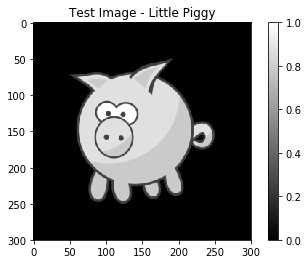

In [15]:
plt.imshow(pig, cmap='gray')
plt.colorbar()
plt.title('Test Image - Little Piggy')

# Addition of Noise

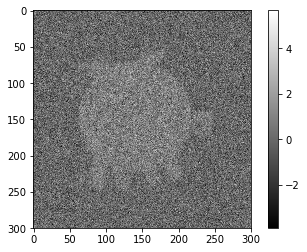

In [27]:
def noisify(image, sigma=1):
    return image + sigma * np.random.randn(*image.shape)
plt.imshow(noisify(pig, 1), cmap='gray')
plt.colorbar()

# Rotation of Test Image

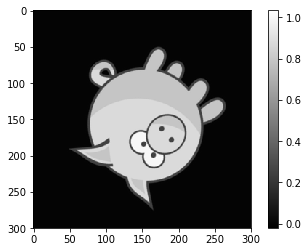

In [50]:
def rotate(image, angle=0):
    return ndimage.interpolation.rotate(image, angle, reshape=False)
plt.imshow(rotate(pig,135), cmap='gray')
plt.colorbar()

# Generation of Initial Structure

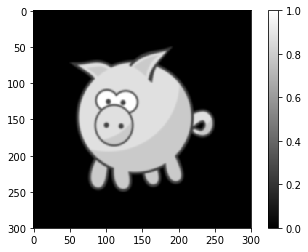

In [368]:
reference = ndimage.filters.gaussian_filter(pig, 1)
plt.imshow(reference, cmap='gray')
plt.colorbar()

# Generation of Test Data

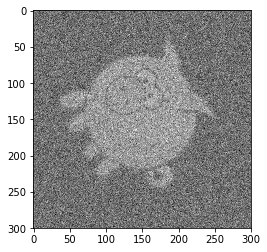

In [387]:
N = 50
noise = 0.5
images_stack = []
angles = np.random.uniform(0,360,N)
for angle in angles:
    pig_rotated = rotate(pig, angle)
    pig_noisy = noisify(pig_rotated, noise)
    images_stack.append(pig_noisy)
images_stack = np.array(images_stack)
plt.imshow(images_stack[-1], cmap='gray')

# Maximum CC Estimate

In [388]:
def logpolar_old(image, angles=360):
    # This takes a numpy array and returns it in Log-Polar coordinate
    
    # Create a cartesian array which will be used to compute log-polar coordinates.
    coordinates = scipy.mgrid[0:max(image.shape)*2,0:360]
    # Compute a normalized logarithmic gradient
    log_r = 10**(coordinates[0,:]/(image.shape[0]*2.)*np.log10(image.shape[1]))
    # Create a linear gradient going from 0 to 2*Pi
    angle = 2.*np.pi*(coordinates[1,:]/360.)

    # Using scipy's map_coordinates(), we map the input array on the log-polar 
    # coordinate. Do not forget to center the coordinates!
    lpinput = ndimage.interpolation.map_coordinates(image,
                                            (log_r*np.cos(angle)+image.shape[0]/2.,
                                             log_r*np.sin(angle)+image.shape[1]/2.),
                                            order=1,mode='constant')

    # Returning log-normal...
    return lpinput

def logpolar(image, angles=360, radii=None):
    """Return log-polar transformed image and log base."""
    shape = image.shape
    center = shape[0] / 2, shape[1] / 2
    if angles is None:
        angles = shape[0]
    if radii is None:
        radii = shape[1]
    theta = np.empty((angles, radii), dtype=np.float64)
    theta.T[:] = -np.linspace(0, np.pi, angles, endpoint=False)
    #d = radii
    d = np.hypot(shape[0]-center[0], shape[1]-center[1])
    log_base = 10.0 ** (np.log10(d) / (radii))
    radius = np.empty_like(theta)
    radius[:] = np.power(log_base, np.arange(radii,
                                                   dtype=np.float64)) - 1.0
    x = radius * np.sin(theta) + center[0]
    y = radius * np.cos(theta) + center[1]
    output = np.empty_like(x)
    ndimage.map_coordinates(image, [x, y], output=output)
    return output.T

In [389]:
angular_resolution =360 #how many divisions of a full circle

images_backrotated = []
angles_inferred = []
fft_logpolar_reference = np.fft.rfft(logpolar_old(reference, angular_resolution))
for image in images_stack:
    Fcorr = np.fft.rfft(logpolar_old(image, angular_resolution)) * fft_logpolar_reference
    correlation = np.fft.irfft(Fcorr).mean(0)
    angle = (np.argmax(correlation)/angular_resolution-0.5)*360
    angles_inferred.append(angle)
    images_backrotated.append(rotate(image, -angle))
images_backrotated = np.array(images_backrotated)
angles_inferred = np.array(angles_inferred)

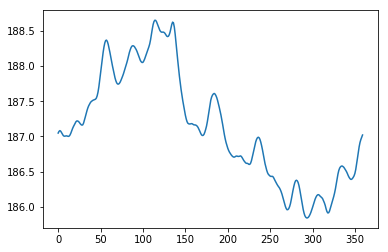

In [390]:
plt.plot(correlation)

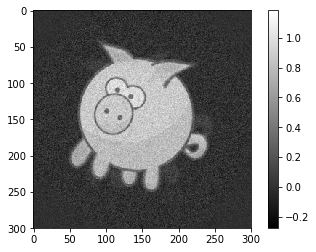

In [391]:
plt.imshow(images_backrotated.mean(0), cmap='gray')
plt.colorbar()

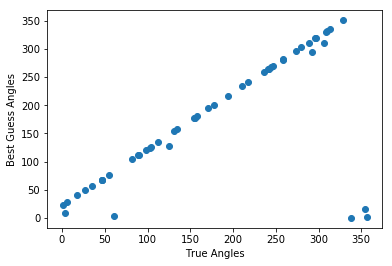

In [392]:
plt.scatter(angles%360, angles_inferred%360)
plt.xlabel('True Angles')
plt.ylabel('Best Guess Angles')

# Time Comparisons

In [87]:
%timeit rotate(pig)

12.4 ms ± 1.64 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [217]:
%timeit logpolar(pig)

44.6 ms ± 3.29 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [220]:
%timeit logpolar2(pig,360)

20.4 ms ± 665 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


# Reconstruct

In [247]:
logpolar(pig).shape

(360, 300)

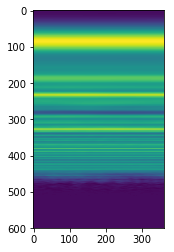

In [310]:
plt.imshow(np.fft.irfft(Fcorr))

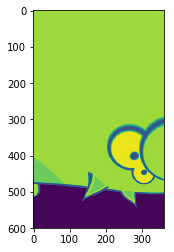

In [333]:
plt.imshow(logpolar(pig, 360, 600))

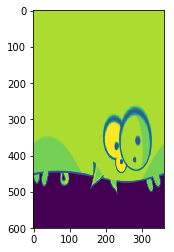

In [328]:
plt.imshow(logpolar_old(pig))